In [1]:
%run Functions.ipynb
%matplotlib inline
import numpy as np
np.random.seed(42)

# Loading and preparing the data

## Preparing the relations

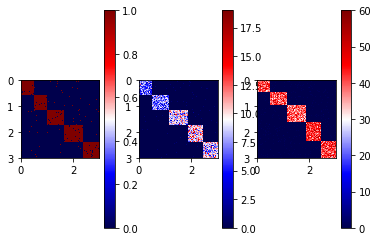

In [2]:
intra = 0.95
inter = 0.05

unique_users, unique_tags, unique_items, pairs, train_set, test_set = synthetic_data(intra, inter)

user_item = np.zeros((len(unique_users), len(unique_items)))
user_tag = np.zeros((len(unique_users), len(unique_tags)))
item_tag = np.zeros((len(unique_items), len(unique_tags)))

i = 0
for a in train_set:
    user_item[unique_users.index(a[0]), unique_items.index(a[1])] = 1
    for entry in pairs[(a[0], a[1])]:
        user_tag[unique_users.index(a[0]), unique_tags.index(entry)] += 1
        item_tag[unique_items.index(a[1]), unique_tags.index(entry)] += 1

Sparseness of matrices

In [3]:
dim = user_item.shape
print ((user_item > 0).sum() / user_item.size)

dim = user_tag.shape
print ((user_tag > 0).sum() / user_tag.size)

dim = item_tag.shape
print ((item_tag > 0).sum() / item_tag.size)

0.148486111111
0.206984848485
0.239621212121


# Recommendation

In [4]:
#random matrix used as baseline
sizeU, sizeI = user_item.shape
random_matrix = np.random.rand(sizeU, sizeI)

In [5]:
predicted = user_tag.dot(item_tag.T)
paths = ((user_tag > 0)*1).dot(((item_tag.T>0)*1))
pred_normalized = normalize(predicted, paths)

print("Baseline: ", recall(evaluate(random_matrix, test_set), 20))

print("Multiplication: ", recall(evaluate(predicted*1., test_set), 20))
print("Paths: ", recall(evaluate(paths*1., test_set), 20))
print("Normalized: ", recall(evaluate(pred_normalized, test_set), 20))

Baseline:  0.200056116723
Multiplication:  0.965207631874
Paths:  0.961840628507
Normalized:  0.966610549944


## Pareto
We can use both predicted value and number of paths together to get the pareto frontier.

In [6]:
print("Pareto: ", recall(evaluate(predicted, test_set, paths), 20))

Pareto:  0.965207631874


# DFMF
Using DFMF we can fill the rest of the matrices and use the new data to make predictions.

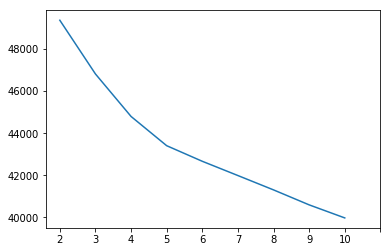

In [7]:
errors = []
n = 1
for i in np.arange(2, 11, 1):
    run_sum = 0
    for _ in range(n):
        G, S = dfmf(i, user_item, user_tag, item_tag)
        G_users, G_items, G_tags = G
        S_user_tag, S_tag_item, S_user_item = S

        err1 = np.ma.masked_equal(user_item, 0) - G_users.dot(S_user_item.dot(G_items.T))
        err1 = np.sqrt(err1**2).sum()
        err2 = np.ma.masked_equal(user_tag, 0) - G_users.dot(S_user_tag.dot(G_tags.T))
        err2 = np.sqrt(err2**2).sum()
        err3 = np.ma.masked_equal(item_tag.T, 0) - G_tags.dot(S_tag_item.dot(G_items.T))
        err3 = np.sqrt(err3**2).sum()
        run_sum += err1 + err2 + err3
    errors.append(run_sum/n)

ticks = np.arange(2, 11, 1)
locs = np.arange(0, 10)
plt.plot(errors)
plt.xticks(locs)
plt.gca().set_xticklabels(ticks);

We can use factor matrices to approximate the original data.

In [8]:
G, S = dfmf(5, user_item, user_tag, item_tag)
G_users, G_items, G_tags = G
S_user_tag, S_tag_item, S_user_item = S

pred_dfmf = G_users.dot(S_user_item.dot(G_items.T))

print("Baseline: ", recall(evaluate(random_matrix, test_set), 20))
print("DFMF: ", recall(evaluate(pred_dfmf, test_set), 20))

Baseline:  0.200056116723
DFMF:  0.184904601571


Since we only know where users added (liked), but not "not added" (disliked), DFMF takes a masked matrix with only 1s visible and tries to fill the new matrix with values close to 1. We can see this in the histogram below. It doesn't help us with recommendation.

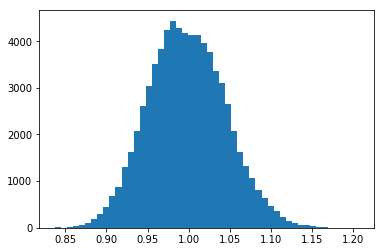

In [9]:
plt.hist(pred_dfmf.flatten(), bins=50);

But we can also approximate the other two matrices and chain them to obtain new predictions.

Chain GSSG:  0.49354657688
Chain:  0.228395061728


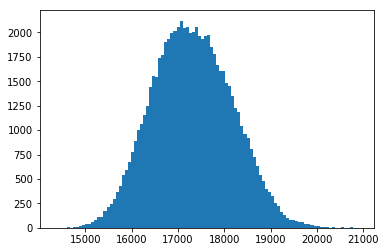

In [10]:
chain_dfmf = G_users.dot(S_user_tag.dot(S_tag_item.dot(G_items.T)))
print("Chain GSSG: ", recall(evaluate(chain_dfmf, test_set), 20))

chain_dfmf = G_users.dot(S_user_tag.dot(G_tags.T.dot(G_tags.dot(S_tag_item.dot(G_items.T)))))
plt.hist(chain_dfmf.flatten(), bins=100);
print("Chain: ", recall(evaluate(chain_dfmf, test_set), 20))

We can now see that the values of the predictions are more diverse.

## Paths with threshold

Since DFMF returns full matrices, we can not just count the number of connections, since all objects are connected. Instead we decide to filter these connections as more or less relevant / strong. We will try this first by setting a global filter and then by setting local filters for each element.

In [11]:
b = G_users.dot(S_user_tag.dot(G_tags.T))
d = G_tags.dot(S_tag_item.dot(G_items.T))

Maximum paths:  0.485409652076 , with filters:  [75, 75]
Maximum filtered values:  0.491021324355 , with filters:  [70, 75]
Maximum pareto:  0.445005611672 , with filters:  [70, 75]
Maximum pareto on filtered:  0.490179573513 , with filters:  [70, 75]


(0.48540965207631875,
 0.49102132435465767,
 0.44500561167227831,
 0.49017957351290686)

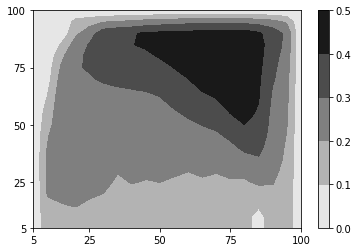

In [12]:
%run Functions.ipynb
matrixFilter(b, d)

Maximum paths:  0.509820426487 , with filters:  [85, 75]
Maximum filtered values:  0.510942760943 , with filters:  [85, 75]
Maximum pareto:  0.486812570146 , with filters:  [65, 70]
Maximum pareto on filtered:  0.511503928171 , with filters:  [50, 80]


(0.50982042648709314,
 0.51094276094276092,
 0.48681257014590346,
 0.51150392817059487)

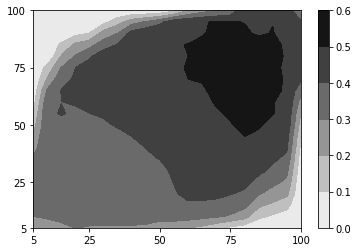

In [13]:
rowFilter(b, d)

## Cross-validation

In [14]:
from sklearn.model_selection import KFold

result = defaultdict(list)
result2 = defaultdict(list)

kf = KFold(n_splits=4)
for train, test in kf.split(train_set):
    X_train, X_test = np.array(train_set)[train], np.array(train_set)[test]

    user_item = np.zeros((len(unique_users), len(unique_items)))
    user_tag = np.zeros((len(unique_users), len(unique_tags)))
    item_tag = np.zeros((len(unique_items), len(unique_tags)))

    i = 0
    for a in X_train:
        user_item[unique_users.index(a[0]), unique_items.index(a[1])] = 1
        for entry in pairs[(a[0], a[1])]:
            user_tag[unique_users.index(a[0]), unique_tags.index(entry)] += 1
            item_tag[unique_items.index(a[1]), unique_tags.index(entry)] += 1            
            
    G, S = dfmf(5, user_item, user_tag, item_tag)
    G_users, G_items, G_tags = G
    S_user_tag, S_tag_item, S_user_item = S
    
    b = G_users.dot(S_user_tag.dot(G_tags.T))
    d = G_tags.dot(S_tag_item.dot(G_items.T))

    for m in range(5,101,5):
        for n in range(5,101,5):
            b_u_p = importantCells(b, m)

            d_u_p = importantCells(d, n)

            r = b_u_p.dot(d_u_p)
            res = recall(evaluate(r, X_test), 20)
            result[m,n].append(res)
            
    for m in range(5,101,5):
        for n in range(5,101,5):        
            b_u_p = importantCells2(b, m)
            d_u_p = importantCells2(d, n, axis=0)

            r = b_u_p.dot(d_u_p)
            res = recall(evaluate(r, X_test), 20)
            result2[m,n].append(res)

In [15]:
maximum = 0
para = [0,0]

for key in result:
    score = np.mean(result[key])
    if score > maximum:
        maximum = score
        para = key
print(maximum, para)

0.396126623017 (80, 75)


In [16]:
maximum = 0
para = [0,0]

for key in result2:
    score = np.mean(result2[key])
    if score > maximum:
        maximum = score
        para = key
print(maximum, para)

0.447945789118 (85, 85)


# Chain matrix factorization

By using matrix factorization it is possible to predict the value of elements missing in the data.
We can speed up calculations by choosing an appropraite multiplication order.

In [17]:
users = len(unique_users)
items = len(unique_items)
tags = len(unique_tags)

R = np.vstack((
    np.hstack((np.zeros((users, users)), user_item, user_tag)),
    np.hstack((np.zeros((items, users)), np.zeros((items, items)), item_tag)),
    np.hstack((np.zeros((tags, users)), np.zeros((tags, items)), np.zeros((tags, tags)))),
    ))

Obtaining $S$ and $G$ from the model

In [18]:
S = np.vstack((
    np.hstack((np.zeros((5, 5)), S_user_item, S_user_tag)),
    np.hstack((np.zeros((5, 5)), np.zeros((5, 5)), S_tag_item.T)),
    np.hstack((np.zeros((5, 5)), np.zeros((5, 5)), np.zeros((5, 5)))),
    ))

G = scipy.linalg.block_diag(G_users, G_items, G_tags)

We measure the average time of various chaining methods and how they compare to $R^2$.

In [19]:
import time
time_R2 = []
time_GS2G = []
time_K = []
time_GSG2 = []
time_GSGGSG = []

for _ in range(100):
    start = time.time()
    R.dot(R)
    end = time.time()
    time_R2.append(end-start)    

    start = time.time()
    G.dot(S).dot(S).dot(G.T)
    end = time.time()
    time_GS2G.append(end-start)
    
    start = time.time()
    K = G.T.dot(G).dot(S)
    G.dot(S).dot(np.linalg.matrix_power(K, 1)).dot(G.T)
    end = time.time()
    time_K.append(end-start)

    start = time.time()
    np.linalg.matrix_power(G.dot(S).dot(G.T), 2)
    end = time.time()
    time_GSG2.append(end-start)
    
    start = time.time()
    G.dot(S).dot(G.T).dot(G).dot(S).dot(G.T)
    end = time.time()
    time_GSGGSG.append(end-start)

print("R²: \t%.4f" % np.mean(time_R2))
print("GS²G: \t%.4f" % np.mean(time_GS2G))
print("GSGGSG: %.4f" % np.mean(time_GSGGSG))
print("(GSG)²: %.4f" % np.mean(time_GSG2))
print("GSKG: \t%.4f" % np.mean(time_K))

print("Speedup:")
print("R²: \t%.4f" % (np.mean(time_R2)/np.mean(time_R2)))
print("GS²G: \t%.4f" % (np.mean(time_R2)/np.mean(time_GS2G)))
print("GSGGSG: %.4f" % (np.mean(time_R2)/np.mean(time_GSGGSG)))
print("(GSG)²: %.4f" % (np.mean(time_R2)/np.mean(time_GSG2)))
print("GSKG: \t%.4f" % (np.mean(time_R2)/np.mean(time_K)))

R²: 	0.0283
GS²G: 	0.0139
GSGGSG: 0.0295
(GSG)²: 0.0400
GSKG: 	0.0140
Speedup:
R²: 	1.0000
GS²G: 	2.0393
GSGGSG: 0.9613
(GSG)²: 0.7090
GSKG: 	2.0259
